# Практическая работа 1 «Разработка сверточной нейронной сети с использованием MXNet или PyTorch»

## Требования:
1. Загрузка данных. Проведена проверка корректности загрузки данных (необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки, совпадение размерностей).
2. Построение архитектуры сверточной сети. Требуется вывести информацию об архитектуре, опционально выполнить визуализацию сети.
3. Обучение модели. Необходимо вывести информацию о параметрах алгоритма обучения. В процессе обучения выведена ошибка классификации и время одной эпохи на тренировочном наборе данных по окончании каждой эпохи. По завершении обучения выведено общее время обучения.
4. Тестирование модели. По завершении обучения должна быть выведена ошибка классификации на тестовом наборе данных.

In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import os
import time
from matplotlib import pyplot as plot
from torchsummary import summary



In [47]:
norm_params = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0]*torch.tensor(norm_params[1]).reshape(3, 1, 1) + torch.tensor(norm_params[0]).reshape(3, 1, 1)
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow((255 * img).astype('uint8'))

## Загрузка данных

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
current_dir = os.getcwd()
size_of_set = 4
# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root=current_dir, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=size_of_set,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=current_dir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=size_of_set,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Number of samples in train dataset: {len(trainset)}")
print(f"Number of samples in test dataset: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Number of samples in train dataset: 50000
Number of samples in test dataset: 10000


## Визуализация данных

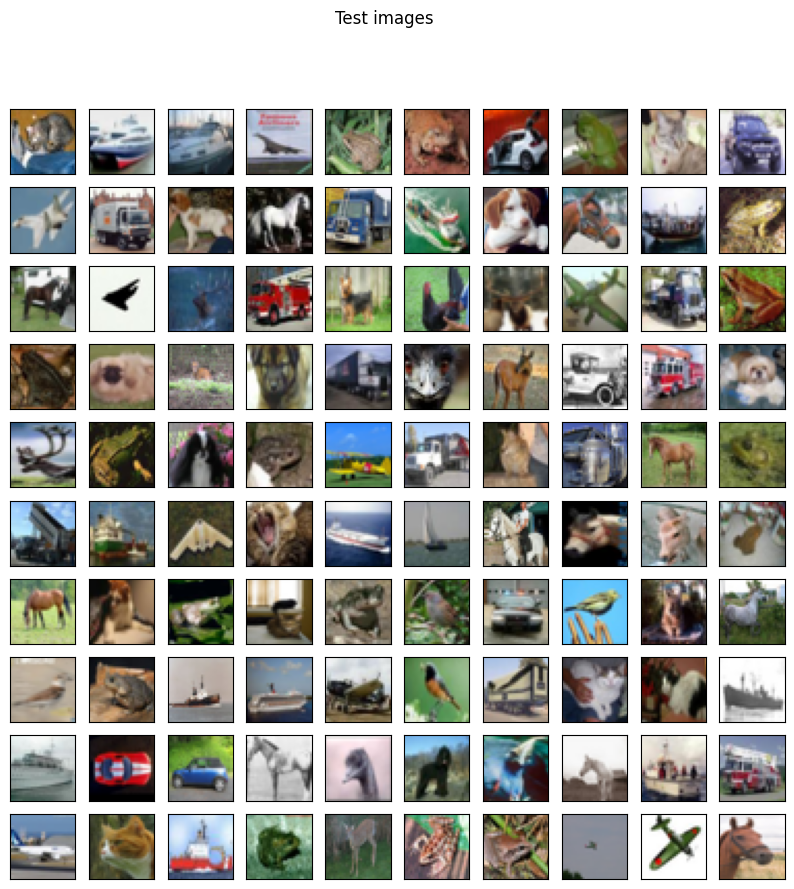

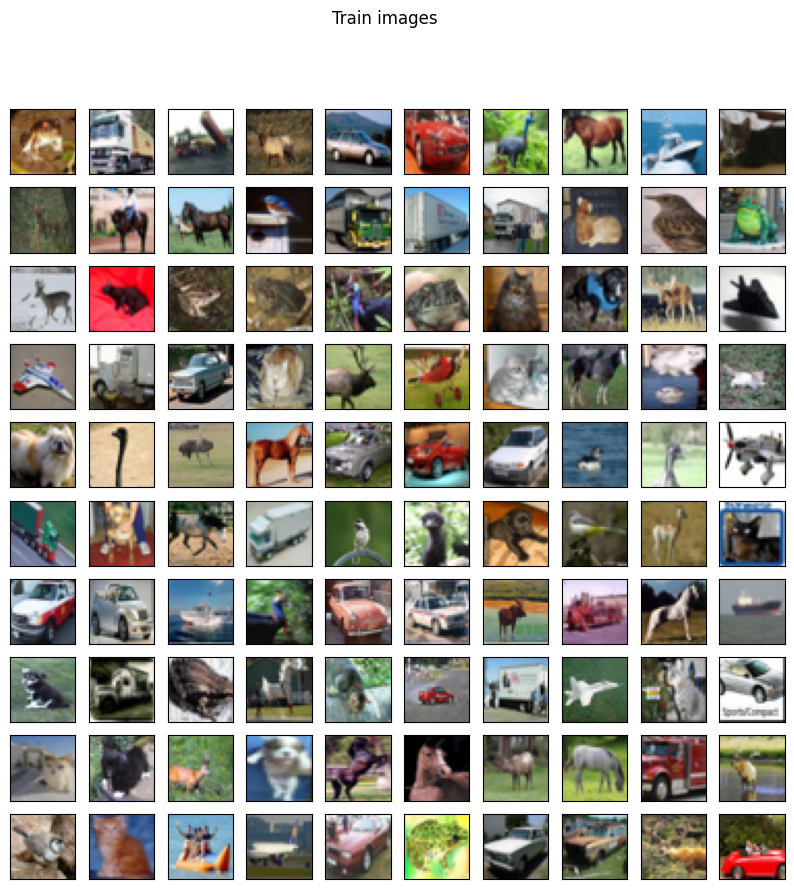

In [49]:
show_images(testset, 'Test images')
show_images(trainset, 'Train images')

## Построение архитектуры сверточной сети

In [50]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

## Визуализация сети

In [51]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         MaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 512]       1,049,088
            Linear-8                  [-1, 256]         131,328
            Linear-9                   [-1, 10]           2,570
Total params: 1,276,234
Trainable params: 1,276,234
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 4.87
Estimated Total Size (MB): 5.43
---------------------------------------

## Обучение модели

In [52]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network
for epoch in range(10):
    start_time = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    epoch_time = time.time() - start_time
    print('Epoch %d took %.2f seconds' % (epoch + 1, epoch_time))

print('Finished training')



[1,  2000] loss: 2.223
[1,  4000] loss: 1.875
[1,  6000] loss: 1.622
[1,  8000] loss: 1.501
[1, 10000] loss: 1.418
[1, 12000] loss: 1.329
Epoch 1 took 147.59 seconds
[2,  2000] loss: 1.203
[2,  4000] loss: 1.162
[2,  6000] loss: 1.097
[2,  8000] loss: 1.050
[2, 10000] loss: 1.010
[2, 12000] loss: 0.973
Epoch 2 took 112.69 seconds
[3,  2000] loss: 0.884
[3,  4000] loss: 0.855
[3,  6000] loss: 0.820
[3,  8000] loss: 0.808
[3, 10000] loss: 0.783
[3, 12000] loss: 0.818
Epoch 3 took 121.17 seconds
[4,  2000] loss: 0.671
[4,  4000] loss: 0.676
[4,  6000] loss: 0.671
[4,  8000] loss: 0.669
[4, 10000] loss: 0.683
[4, 12000] loss: 0.672
Epoch 4 took 130.47 seconds
[5,  2000] loss: 0.528
[5,  4000] loss: 0.542
[5,  6000] loss: 0.547
[5,  8000] loss: 0.546
[5, 10000] loss: 0.547
[5, 12000] loss: 0.559
Epoch 5 took 107.48 seconds
[6,  2000] loss: 0.392
[6,  4000] loss: 0.414
[6,  6000] loss: 0.423
[6,  8000] loss: 0.433
[6, 10000] loss: 0.453
[6, 12000] loss: 0.460
Epoch 6 took 111.50 seconds
[7, 

## Тестирование модели

In [53]:
# Test the network on the test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 75.74 %
